In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import csv
from datetime import datetime


import pickle

import random
from matplotlib.ticker import FuncFormatter

import pickle

---

In [2]:
birth_data_raw = pd.read_csv('birth_Canada.csv', delimiter=';')
birth_data_raw.shape

(403, 16)

<Axes: xlabel='date'>

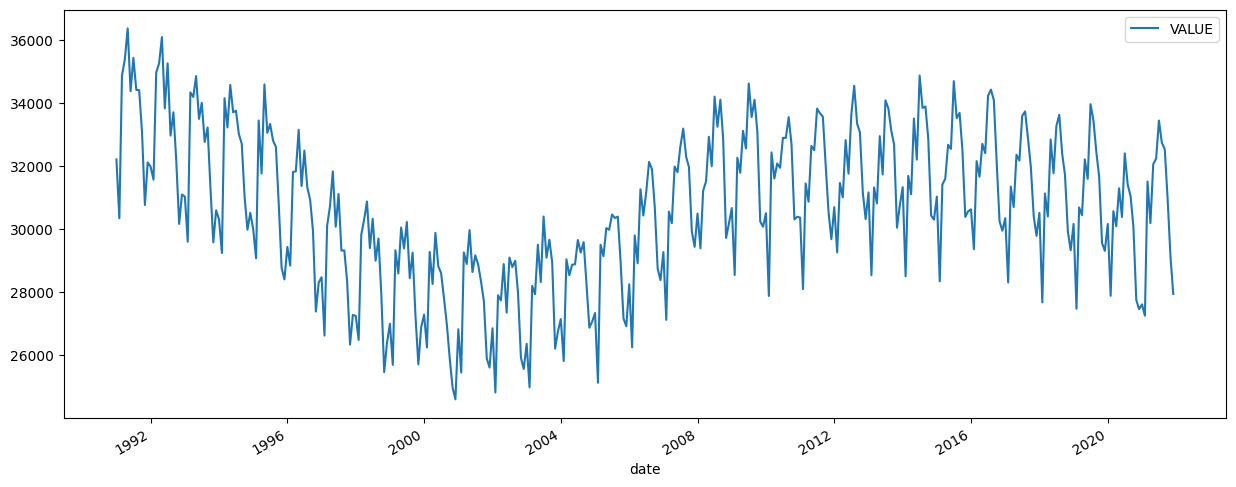

In [3]:
df = birth_data_raw.copy()

month_to_num = {
    'Month of birth, January': '01',
    'Month of birth, February': '02',
    'Month of birth, March': '03',
    'Month of birth, April': '04',
    'Month of birth, May': '05',
    'Month of birth, June': '06',
    'Month of birth, July': '07',
    'Month of birth, August': '08',
    'Month of birth, September': '09',
    'Month of birth, October': '10',
    'Month of birth, November': '11',
    'Month of birth, December': '12'
}

# Map the 'Month of birth' to a number
df['Month'] = df['Month of birth'].map(month_to_num)

# Ignore rows with 'Total, month of birth'
df = df[df['Month'].notna()]

# Combine the 'REF_DATE' column (as string) and 'Month' to create a new 'date' column
df['date'] = pd.to_datetime(df['REF_DATE'].astype(str) + df['Month'], format='%Y%m')

# Select only the 'date' and 'VALUE' columns for the timeseries
birth_data = df[['date', 'VALUE']]

birth_data.plot(x='date', y='VALUE', figsize=(15, 6))

---

In [4]:
death_data_raw = pd.read_csv('death_Canada.csv', delimiter=',')
death_data_raw.shape

(780, 15)

In [5]:
death_data_raw.head(2)

,"REF_DATE,""GEO;""""""","DGU"";""ID"""""";""","Month of death""""","Characteristics""""","UOM""""","UO"";""M_ID""""","SCALAR_FACTOR""""","SCALAR_ID""""","VECTOR""""","COORDINATE""""","VALUE""""","STATUS""""","SYMBOL""""","TERMINATED""""","DECIMALS"""""""
"1991,""Canada,;place;of;""residence""""","2016A000011124""""",Total,"month of"";""death""""","Number of deaths""""","Number""""","223""""","units""""","0""""","v21216330""""","1.1.1""""","195569""""","""","""","""","0"""""""
"1992,""Canada,;place;of;""residence""""","2016A000011124""""",Total,"month of"";""death""""","Number of deaths""""","Number""""","223""""","units""""","0""""","v21216330""""","1.1.1""""","196535""""","""","""","""","0"""""""


In [6]:
def parse_file(file_path):
    dates = []
    indices = []
    values = []

    with open(file_path, 'r') as file:
        next(file)  # skip the header line
        for line in file:
            if "Total, month of" in line:
                continue  # skip the line if it contains "Total, month of"

            fields = [field.replace('"', '') for field in line.strip().split('","')]
            fields = [field.split(';') if ';' in field else field for field in fields]

            # Parse date
            year = int(fields[0][0].split(",")[0])  # get the year from the first field

            # Try to locate the month, skip line if "Total, month of" is found
            month = "January"
            total_month_of = False
            for field in fields:
                if type(field) == list and "Total, month of" in field:
                    total_month_of = True
                    break
                if type(field) == list and "Month of death," in field:
                    month_index = field.index("Month of death,") + 1
                    if month_index < len(field):
                        month = field[month_index]

            # Convert month name to month number
            month_number = datetime.strptime(month, "%B").month
            date = datetime(year, month_number, 1)  # use first day of the month for date

            # Parse index and value
            index = fields[3]
            value = fields[10]

            dates.append(date)
            indices.append(index)
            values.append(float(value))  # convert value to float

    return dates, indices, values

file_path = 'death_Canada.csv'  # replace with your actual file path
dates, indices, values = parse_file(file_path)

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'indice': indices,
    'value': values
})

# Print DataFrame
df.head(2)

,date,indice,value
0,1991-01-01,Number of deaths,17459.0
1,1992-01-01,Number of deaths,18353.0


<Axes: xlabel='date'>

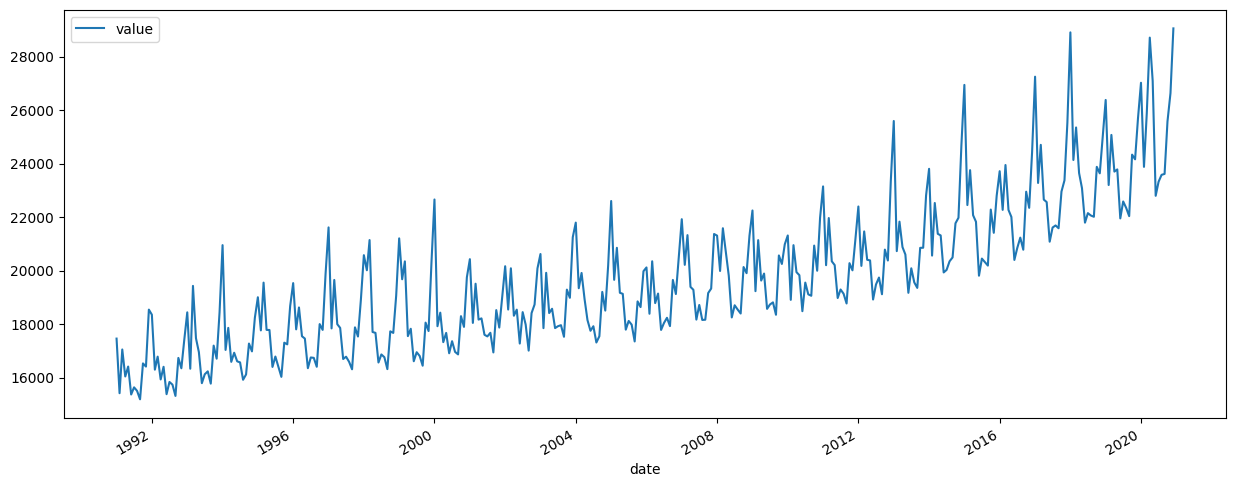

In [7]:
df[df['indice'] == 'Number of deaths'].plot(x='date', y='value', figsize=(15, 6))

In [8]:
df['indice'].unique()

array(['Number of deaths', 'Percentage of deaths'], dtype=object)

In [9]:
death_data = df.copy()

---

# Divorce

In [10]:
divorce_data_raw = pd.read_csv('divorces_Canada.csv', delimiter=';')
divorce_data_raw.shape

(452, 15)

In [11]:
divorce_data_raw.sample(5)

,REF_DATE,GEO,DGUID,Indicator,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
48,2018,Canada,2016A000011124,Number of divorces,Number,223,units,0,v1331258926,01.янв,61344,NaN,NaN,NaN,0
58,1977,Canada,2016A000011124,Crude divorce rate,"Rates per 1,000 population",267,units,0,v1331258927,01.фев,2.344,NaN,NaN,NaN,3
143,2002,Canada,2016A000011124,Age-standardized divorce rate,"Rate per 1,000 married persons",424,units,0,v1331258929,01.апр,12.фев,NaN,NaN,NaN,1
20,1990,Canada,2016A000011124,Number of divorces,Number,223,units,0,v1331258926,01.янв,81195,NaN,NaN,NaN,0
333,1988,Canada,2016A000011124,Median duration of marriage,Years,308,units,0,v1331258933,01.авг,10.авг,NaN,NaN,NaN,1


<Axes: xlabel='date'>

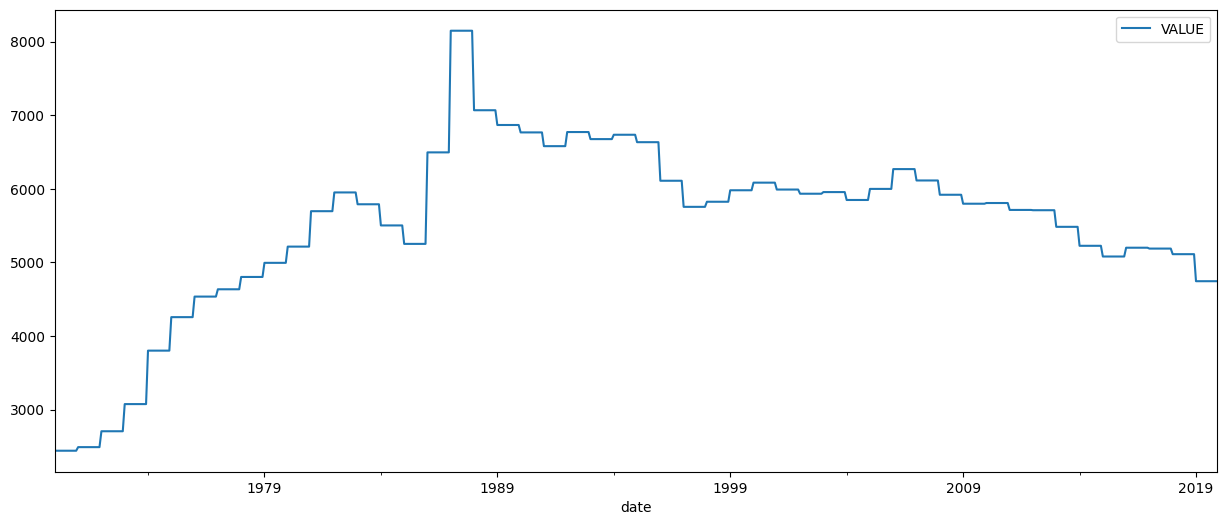

In [12]:
df = divorce_data_raw.copy()

# Concatenate 'REF_DATE' and 'COORDINATE' to form 'date'
df['date'] = df['REF_DATE'].astype(str)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y')
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')

# Create a new DataFrame with the required columns
new_df = df[['date', 'Indicator', 'VALUE']].copy()

# Rename the columns
new_df.rename(columns={'Indicator': 'indice', 'VALUE': 'VALUE'}, inplace=True)


# Set date column as index
new_df['date'] = pd.to_datetime(new_df['date'])
new_df.set_index('date', inplace=True)
new_df = new_df[new_df.indice == 'Number of divorces']
# Resampling
df_resampled = new_df.resample('MS').asfreq()

# Forward fill the NaN values
df_resampled['VALUE'] = df_resampled['VALUE'] / 12
df_resampled['VALUE'] = df_resampled['VALUE'].ffill()
df_resampled['indice'] = df_resampled['indice'].ffill()

# Select only the 'date' and 'VALUE' columns for the timeseries
divorce_data = df_resampled
divorce_data['date'] = divorce_data.index
# delete last point
divorce_data = divorce_data.iloc[:-1]
divorce_data.plot(x='date', y='VALUE', figsize=(15, 6))


---

# Marriage

In [13]:
marriage_data_raw = pd.read_csv('marriage_Canada.csv', delimiter=';')
marriage_data_raw.shape

(150, 15)

In [14]:
marriage_data_raw.sample(2)

,REF_DATE,GEO,DGUID,Indicator,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
42,2003,Canada,2016A000011124,Crude marriage rate,"Rates per 1,000 population",267,units,0,v1446862467,01.июн,04.июл,NaN,NaN,NaN,1
116,2017,Canada,2016A000011124,"Total first-marriage rate before age 80, all g...","Rates per 1,000 population",267,units,0,v1446862563,01.окт,475.9,NaN,NaN,NaN,1


In [15]:
df = marriage_data_raw.copy()

# Concatenate 'REF_DATE' and 'COORDINATE' to form 'date'
df['date'] = df['REF_DATE'].astype(str)
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y')
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')


<Axes: xlabel='date'>

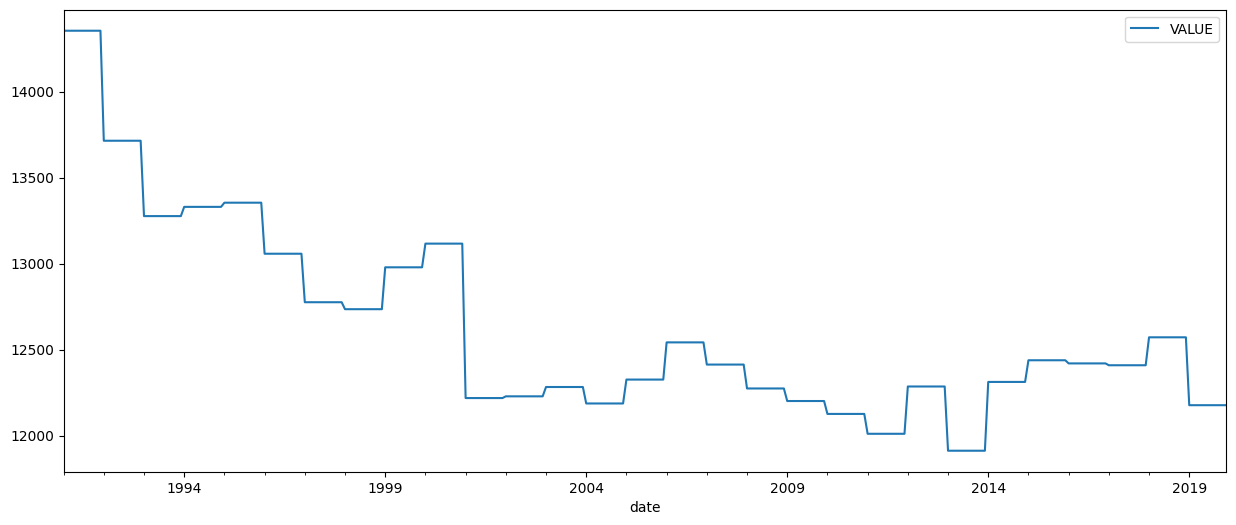

In [16]:

# Create a new DataFrame with the required columns
new_df = df[['date', 'Indicator', 'VALUE']].copy()

# Rename the columns
new_df.rename(columns={'Indicator': 'indice', 'VALUE': 'VALUE'}, inplace=True)


# Set date column as index
new_df['date'] = pd.to_datetime(new_df['date'])
new_df.set_index('date', inplace=True)
new_df = new_df[new_df.indice == 'Number of marriages, total']
# Resampling
df_resampled = new_df.resample('MS').asfreq()

# Forward fill the NaN values
df_resampled['VALUE'] = df_resampled['VALUE'] / 12
df_resampled['VALUE'] = df_resampled['VALUE'].ffill()
df_resampled['indice'] = df_resampled['indice'].ffill()

# Select only the 'date' and 'VALUE' columns for the timeseries
marriage_data = df_resampled
marriage_data['date'] = marriage_data.index
# delete last point
marriage_data = marriage_data.iloc[:-1]
marriage_data.plot(x='date', y='VALUE', figsize=(15, 6))

---

In [17]:
print(birth_data.head(2))
print(death_data.head(2))
print(divorce_data.head(2))
print(marriage_data.head(2))


         date  VALUE
31 1991-01-01  32213
32 1992-01-01  31982
        date            indice    value
0 1991-01-01  Number of deaths  17459.0
1 1992-01-01  Number of deaths  18353.0
                        indice    VALUE       date
date                                              
1970-01-01  Number of divorces  2441.75 1970-01-01
1970-02-01  Number of divorces  2441.75 1970-02-01
                                indice     VALUE       date
date                                                       
1991-01-01  Number of marriages, total  14354.25 1991-01-01
1991-02-01  Number of marriages, total  14354.25 1991-02-01


In [18]:
birth_data = birth_data.rename(columns={"VALUE": "value"})
birth_data["indice"] = "Number of births"  # Adding a new column 'indice' to the birth_data 

death_data = death_data.rename(columns={"value": "value"})
# 'indice' column already exists in death_data

divorce_data = divorce_data.rename(columns={"VALUE": "value"})
divorce_data["indice"] = "Number of divorces"  # Adding a new column 'indice' to the divorce_data 

marriage_data = marriage_data.rename(columns={"VALUE": "value"})
marriage_data["indice"] = "Number of marriages"  # Adding a new column 'indice' to the marriage_data 

# Then, concatenate all the dataframes
all_data = pd.concat([birth_data, death_data, divorce_data, marriage_data])

# If you want to sort this data by date
all_data = all_data.sort_values(by='date')

print(all_data)

                          date     value              indice
1970-01-01 00:00:00 1970-01-01   2441.75  Number of divorces
1970-02-01 00:00:00 1970-02-01   2441.75  Number of divorces
1970-03-01 00:00:00 1970-03-01   2441.75  Number of divorces
1970-04-01 00:00:00 1970-04-01   2441.75  Number of divorces
1970-05-01 00:00:00 1970-05-01   2441.75  Number of divorces
...                        ...       ...                 ...
278                 2021-08-01  32744.00    Number of births
309                 2021-09-01  32542.00    Number of births
340                 2021-10-01  31006.00    Number of births
371                 2021-11-01  29140.00    Number of births
402                 2021-12-01  27943.00    Number of births

[2040 rows x 3 columns]


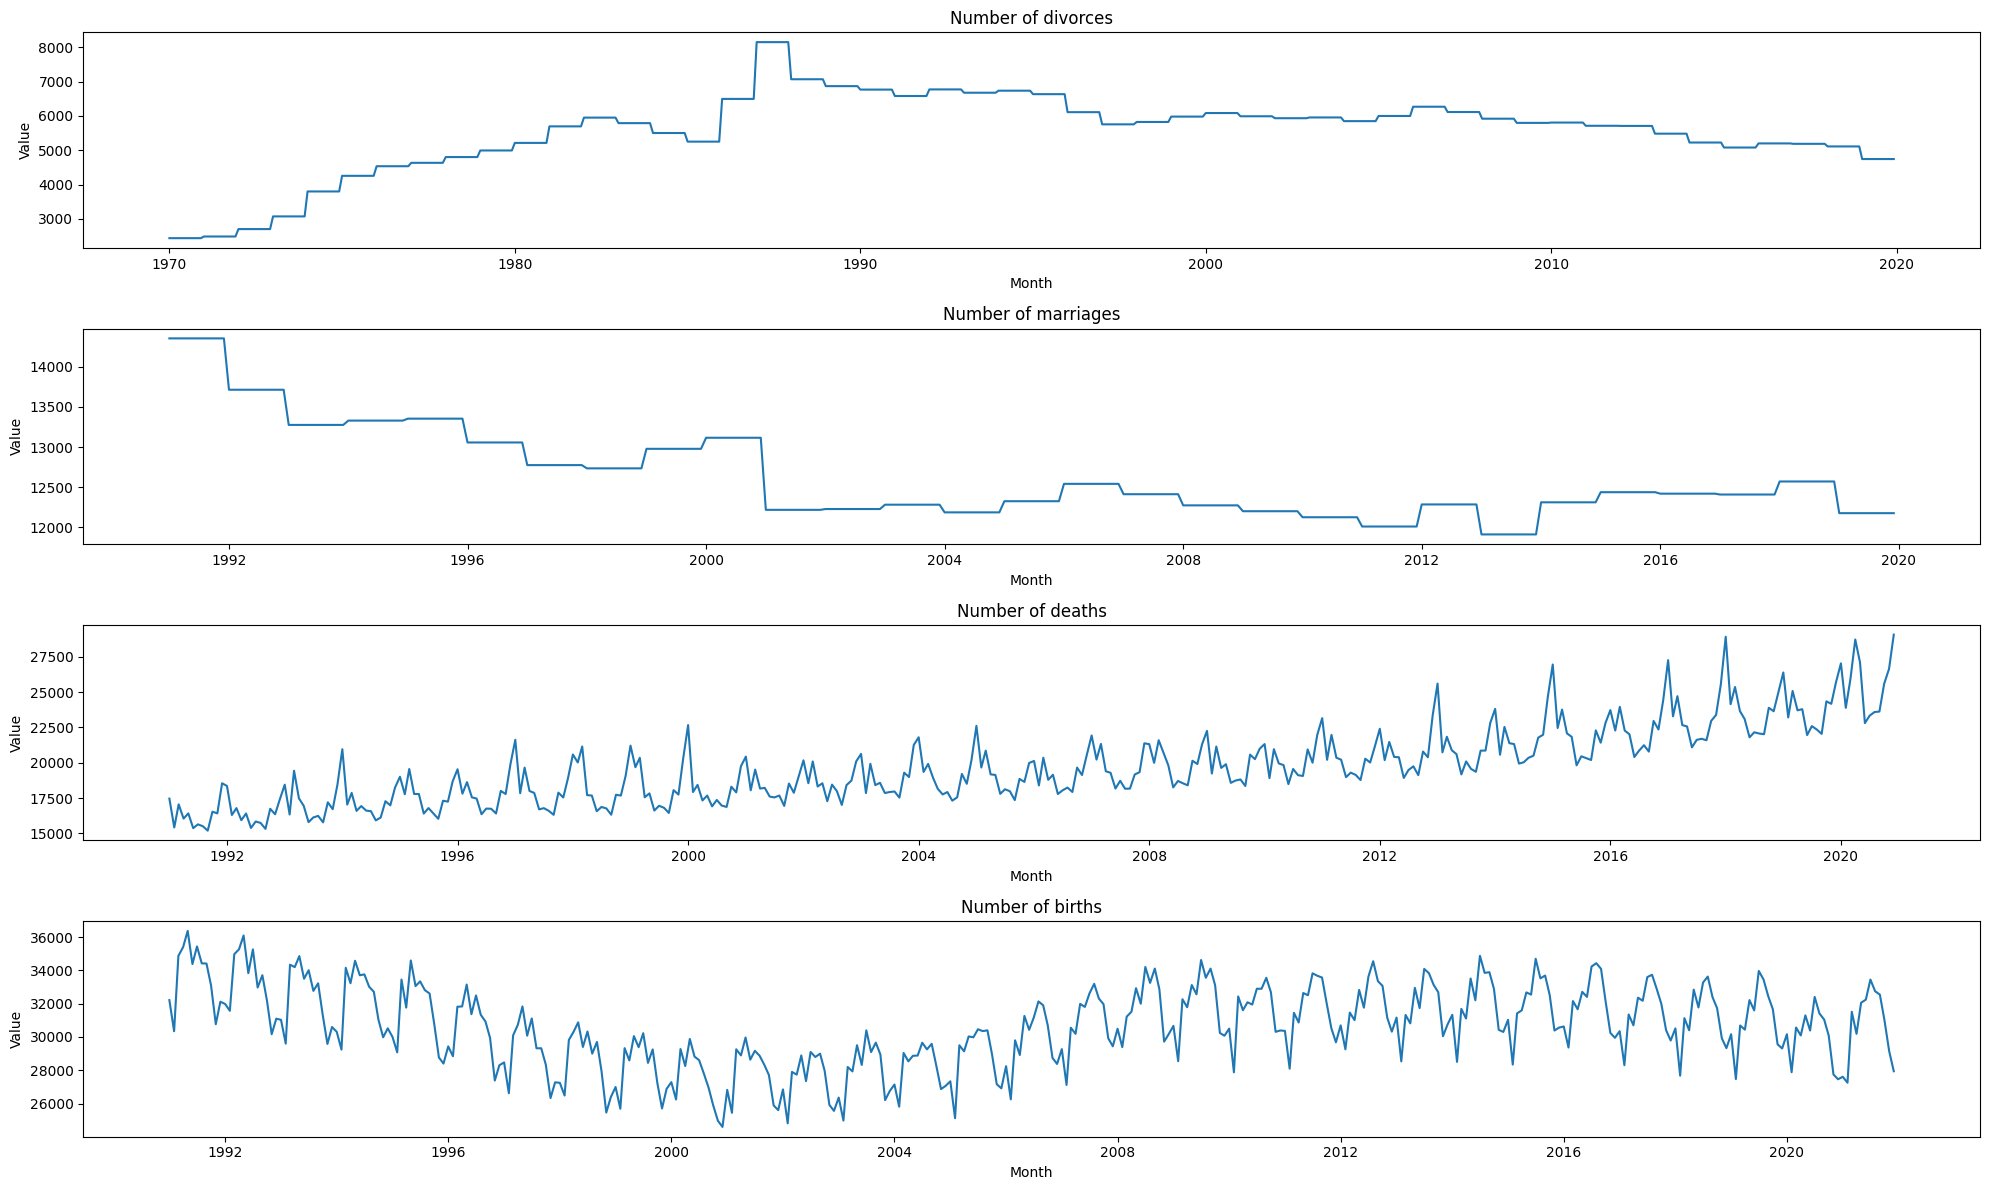

In [19]:
# Create a list of unique indices
indices = all_data['indice'].unique()
# remove 'Percentage of deaths' from the list
indices = indices[indices != 'Percentage of deaths']    

# Create a figure and a grid of subplots
fig, axs = plt.subplots(len(indices), 1, figsize=(20, 3*len(indices)))

for index, indice in enumerate(indices):
    # Filter data for the current indice
    data = all_data[all_data['indice'] == indice]
    
    # Plot data on the subplot
    axs[index].plot(data['date'], data['value'])
    
    # Set title for the subplot
    axs[index].set_title(indice)
    
    # Optionally set x and y labels
    axs[index].set_xlabel('Month')
    axs[index].set_ylabel('Value')

# Improve layout
plt.tight_layout()
plt.show()

In [20]:
all_data.to_pickle("all_data.pkl")

---

In [21]:
file_path = "World_Bank_Data_Canada_Development_Indicators.xlsx"

df = pd.read_excel(file_path, sheet_name="Data", index_col=0)

In [22]:
df.head(2)

,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
Country Name,,,,,,,,,,,,,,,,,,,,,
Canada,CAN,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,57.303,55.546,52.37,50.662,48.539,47.892,46.879,...,11.665,10.859,9.685,8.607,8.054,7.094,6.888,6.985,..,..
Canada,CAN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,26.7,26,25.2,24.6,23.4,21.3,19.3,...,10.9,10.9,10.7,10.6,10.3,10.1,9.9,9.5,9.6,..


In [23]:
# These columns will be kept unchanged
id_vars = ["Country Code", "Series Name", "Series Code"]

# Prepare a list with the names of all year columns
value_vars = [str(year) + " [YR" + str(year) + "]" for year in range(1960, 2023)]

# Use melt to reshape the DataFrame
df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name="Year", value_name="Value")

# The "Year" column currently has a format like "1960 [YR1960]". We will clean this to keep only the year
df_melted["Year"] = df_melted["Year"].str.slice(0, 4).astype(int)

del df_melted["Country Code"]

In [24]:
df_melted.sample(5)

,Series Name,Series Code,Year,Value
22124,Time required to register property (days),IC.PRP.DURS,1974,..
87613,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,2019,3109.043058
76382,Losses due to theft and vandalism (% of annual...,IC.FRM.CRIM.ZS,2011,..
25625,Energy intensity level of primary energy (MJ/$...,EG.EGY.PRIM.PP.KD,1977,..
90533,"Adjusted net savings, including particulate em...",NY.ADJ.SVNG.GN.ZS,2021,7.584408


In [25]:
# Replace '..' with np.nan
df_melted['Value'] = df_melted['Value'].replace('..', np.nan)

# Convert 'Value' to numeric type
df_melted['Value'] = pd.to_numeric(df_melted['Value'])

# Calculate the percentage of missing values in each series
missing_percentage = df_melted.groupby("Series Name")["Value"].apply(lambda x: x.isnull().mean())

# Identify the series with more than 25% missing values
series_to_drop = missing_percentage[missing_percentage > 0.25].index

print(series_to_drop.shape)

(1085,)


In [26]:
# Drop these series
df_melted = df_melted[~df_melted["Series Name"].isin(series_to_drop)]
print(df_melted["Series Name"].nunique())   

393


In [27]:
# Now interpolate missing values in the remaining series
# Note: this will only interpolate within each series, not across different series
df_melted["Value"] = df_melted.groupby("Series Name")["Value"].apply(lambda group: group.interpolate())

C:\Users\p.vladimirov\AppData\Local\Temp\ipykernel_14004\2068088621.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_melted["Value"] = df_melted.groupby("Series Name")["Value"].apply(lambda group: group.interpolate())


In [28]:
len(df_melted["Series Name"].unique())

394

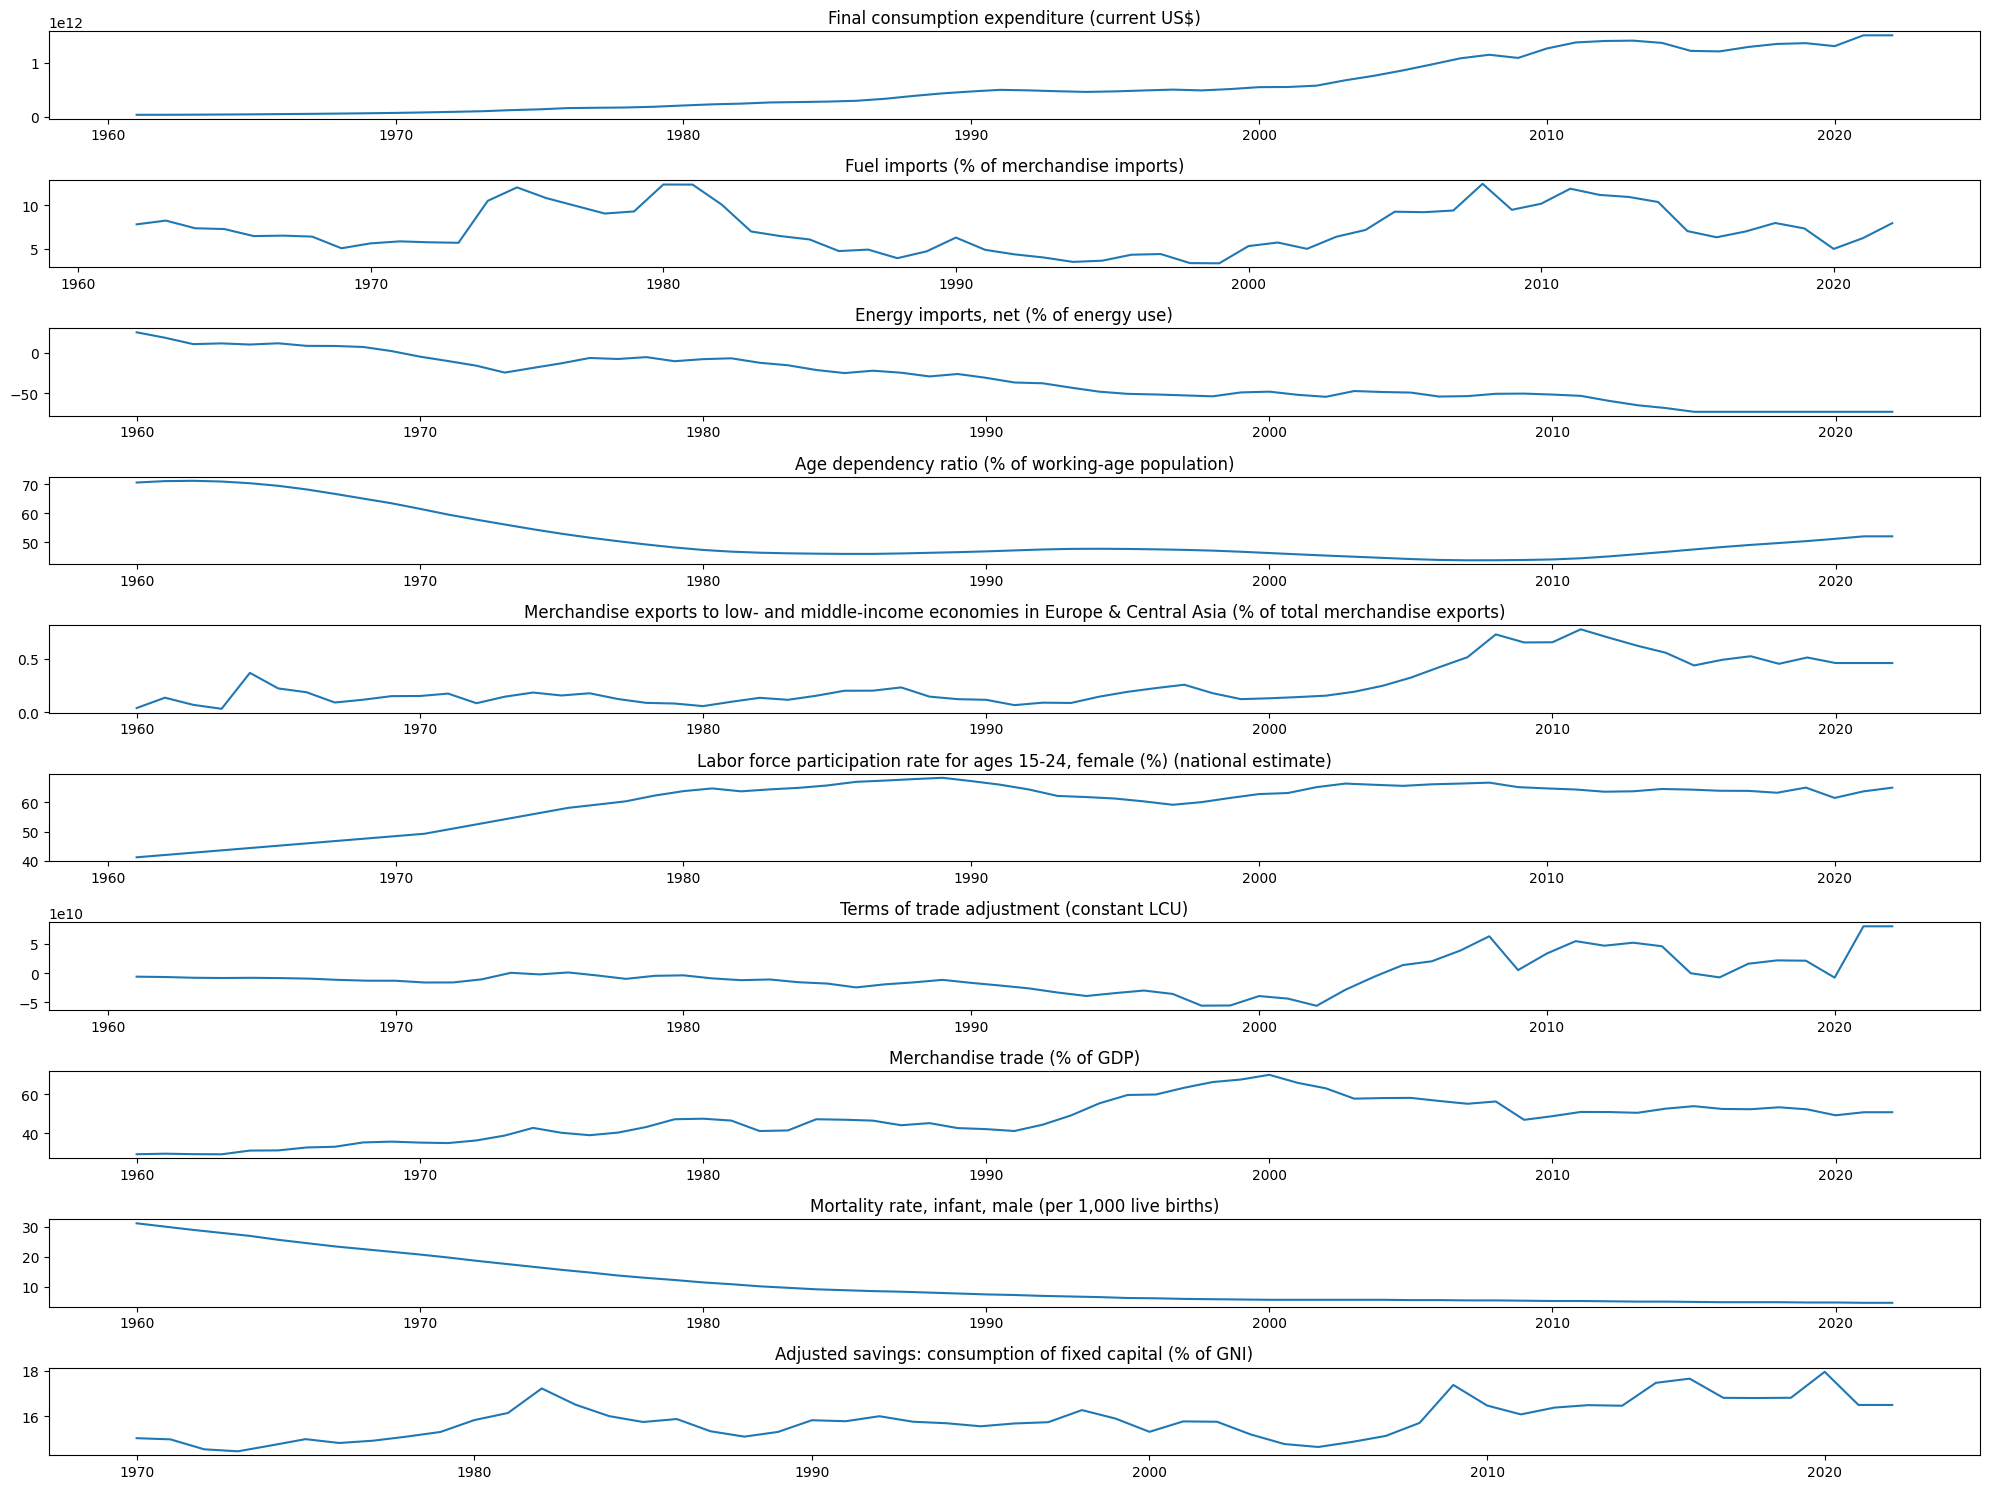

In [29]:
# First, let's create a list of all unique Series Names left
series_names = df_melted["Series Name"].unique()

# Let's select a random sample of 5 series
random_series = random.sample(list(series_names), 10)

# Now we create a figure with 5 subplots
fig, axes = plt.subplots(len(random_series), 1, figsize=(20, 15))

for i, series_name in enumerate(random_series):
    # Select the data for this series
    data = df_melted[df_melted["Series Name"] == series_name]
    
    # Plot the data on the i-th subplot
    axes[i].plot(data["Year"], data["Value"])
    
    # Set the title for this subplot to the series name
    axes[i].set_title(series_name)

# Automatically adjust the subplot layout to provide better spacing
plt.tight_layout()

# Show the figure
plt.show()

In [30]:
series_names

array(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Birth rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, infant, female (per 1,000 live births)',
       'Mortality rate, infant, male (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Mortality rate, under-5, female (per 1,000 live births)',
       'Mortality rate, under-5, male (per 1,000 live births)',
       'Sex ratio at birth (male births per female births)',
       'Death rate, crude (per 1,000 people)', 'Number of infant deaths',
       'Number of neonatal deaths', 'Number of under-five deaths',
       'Adjusted net national income (annual %

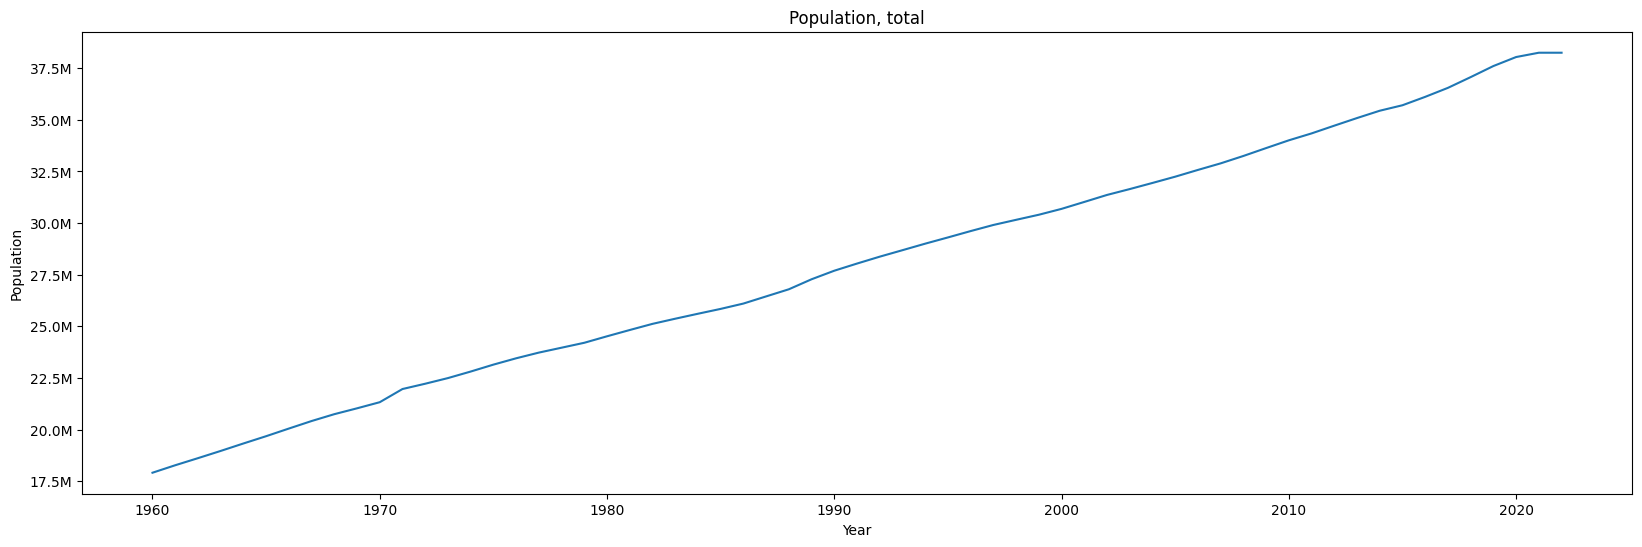

In [31]:
# Function to convert large numbers into millions
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

# Create a formatter
formatter = FuncFormatter(millions)

data = df_melted[df_melted["Series Name"] == "Population, total"]
fig, ax = plt.subplots(figsize=(20,6))

ax.yaxis.set_major_formatter(formatter)

ax.plot("Year", "Value", data=data)
ax.set_title('Population, total')
ax.set_xlabel('Year')
ax.set_ylabel('Population')

plt.show()

In [32]:
df_melted.to_pickle("WB_statistics.pkl")

---

---

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = all_data.copy()

In [43]:
df_deaths = df[df['indice'] == 'Number of deaths']
df_births = df[df['indice'] == 'Number of births']

# Ensure 'date' is in datetime format
df_deaths['date'] = pd.to_datetime(df_deaths['date'])
df_births['date'] = pd.to_datetime(df_births['date'])

# Set 'date' as the index of your dataframe
df_deaths.set_index('date', inplace=True)
df_births.set_index('date', inplace=True)

C:\Users\p.vladimirov\AppData\Local\Temp\ipykernel_14004\4216422326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deaths['date'] = pd.to_datetime(df_deaths['date'])
C:\Users\p.vladimirov\AppData\Local\Temp\ipykernel_14004\4216422326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_births['date'] = pd.to_datetime(df_births['date'])


In [61]:
def optimize_SARIMA(parameters_list, seasonal_parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        for seasonal_param in seasonal_parameters_list:
            try:
                model = SARIMAX(exog, order=(param[0], d, param[1]), 
                                seasonal_order=(seasonal_param[0], D, seasonal_param[1], s)).fit(disp=-1)
            except:
                continue
                
            aic = model.aic
            results.append([param, seasonal_param, model.aic])
            
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', '(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q)
parameters_list = list(parameters)
seasonal_parameters = product(P, Q)
seasonal_parameters_list = list(seasonal_parameters)

result_df_deaths = optimize_SARIMA(parameters_list, seasonal_parameters_list, 1, 1, s, df_deaths['value'])
result_df_births = optimize_SARIMA(parameters_list, seasonal_parameters_list, 1, 1, s, df_births['value'])


In [62]:
best_model_parameters_deaths = result_df_deaths.iloc[0, 0]
best_seasonal_parameters_deaths = result_df_deaths.iloc[0, 1]
best_model_parameters_births = result_df_births.iloc[0, 0]
best_seasonal_parameters_births = result_df_births.iloc[0, 1]

print(f'Best model parameters for deaths: {best_model_parameters_deaths} and {best_seasonal_parameters_deaths}')
print(f'Best model parameters for births: {best_model_parameters_births} and {best_seasonal_parameters_births}')


Best model parameters for deaths: (1, 2) and (2, 1)
Best model parameters for births: (2, 0) and (2, 3)


In [63]:
# Split the data
train_deaths = df_deaths.iloc[:df_deaths.shape[0]*75//100]['value']
test_deaths = df_deaths.iloc[df_deaths.shape[0]*75//100:]['value']

train_births = df_births.iloc[:df_births.shape[0]*75//100]['value']
test_births = df_births.iloc[df_births.shape[0]*75//100:]['value']

In [51]:
# Fit the SARIMA model with the best parameters
model_deaths = SARIMAX(train_deaths, order=(best_model_parameters_deaths[0], d, best_model_parameters_deaths[1]), 
                       seasonal_order=(best_seasonal_parameters_deaths[0], D, best_seasonal_parameters_deaths[1], s))
model_deaths_fit = model_deaths.fit(disp=0)

model_births = SARIMAX(train_births, order=(best_model_parameters_births[0], d, best_model_parameters_births[1]), 
                       seasonal_order=(best_seasonal_parameters_births[0], D, best_seasonal_parameters_births[1], s))
model_births_fit = model_births.fit(disp=0)

# Prediction
forecast_deaths = model_deaths_fit.forecast(steps=len(test_deaths))
forecast_births = model_births_fit.forecast(steps=len(test_births))

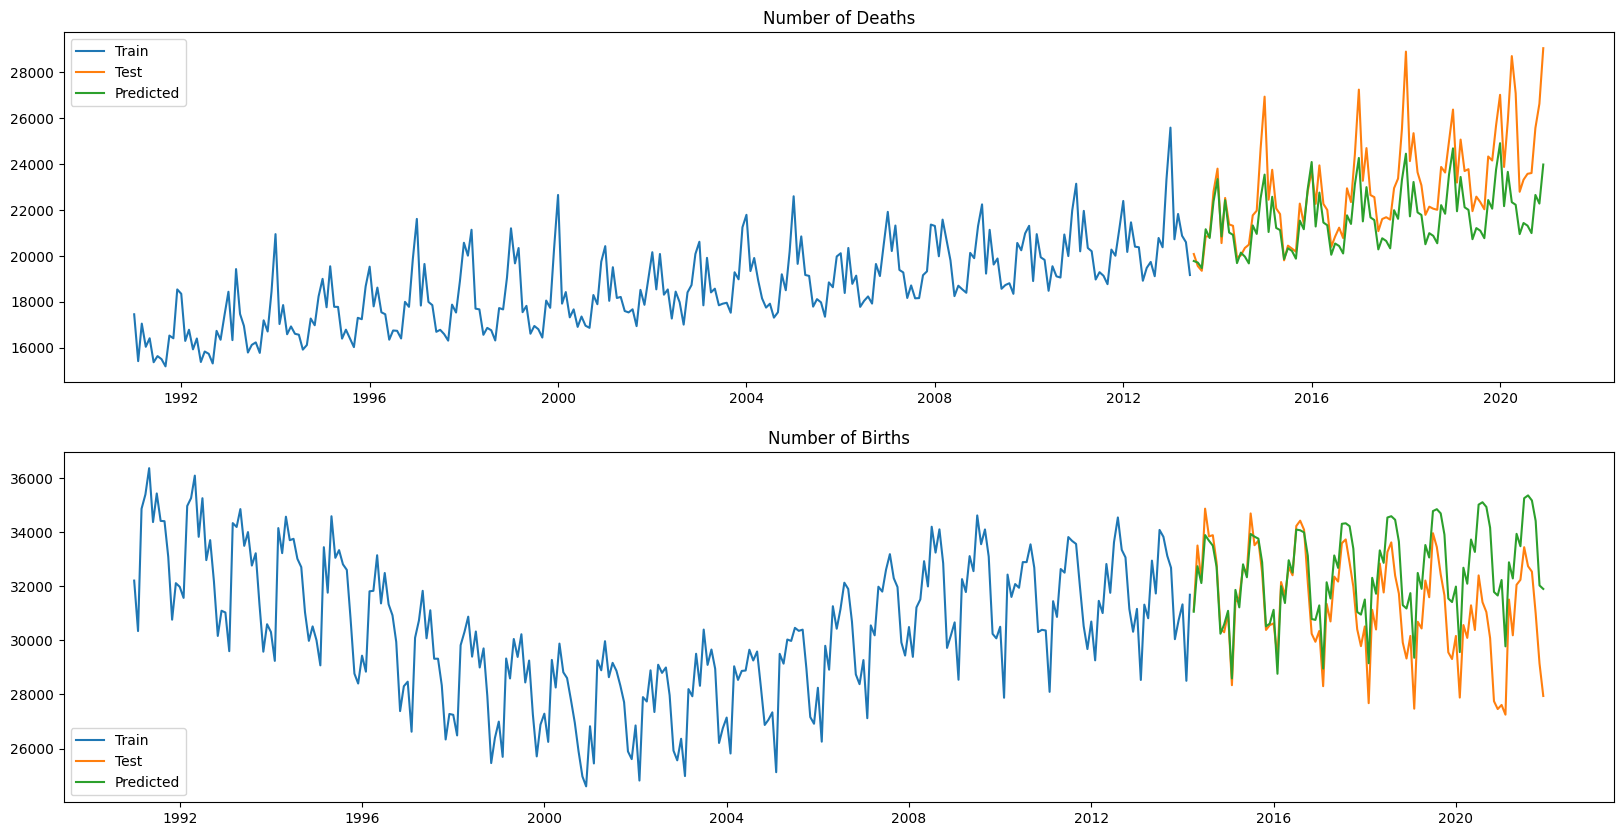

In [60]:
# Plot actual vs predicted
fig, axs = plt.subplots(2, figsize=(20,10))

# plot for deaths
axs[0].plot(train_deaths, label='Train')
axs[0].plot(test_deaths, label='Test')
axs[0].plot(forecast_deaths, label='Predicted')
axs[0].legend(loc='best')
axs[0].set_title('Number of Deaths')

# plot for births
axs[1].plot(train_births, label='Train')
axs[1].plot(test_births, label='Test')
axs[1].plot(forecast_births, label='Predicted')
axs[1].legend(loc='best')
axs[1].set_title('Number of Births')

plt.show()

In [54]:
# Naive prediction: repeat the last 12 months
naive_deaths = np.resize(train_deaths[-12:].values, len(test_deaths))
naive_births = np.resize(train_births[-12:].values, len(test_births))

# Calculate MSE for SARIMA predictions
mse_sarima_deaths = mean_squared_error(test_deaths, forecast_deaths)
mse_sarima_births = mean_squared_error(test_births, forecast_births)

# Calculate MSE for naive predictions
mse_naive_deaths = mean_squared_error(test_deaths, naive_deaths)
mse_naive_births = mean_squared_error(test_births, naive_births)

print(f'MSE for SARIMA predictions (deaths): {mse_sarima_deaths}')
print(f'MSE for naive predictions (deaths): {mse_naive_deaths}')
print(f'MSE for SARIMA predictions (births): {mse_sarima_births}')
print(f'MSE for naive predictions (births): {mse_naive_births}')

MSE for SARIMA predictions (deaths): 3248406.9922301015
MSE for naive predictions (deaths): 6834592.744444445
MSE for SARIMA predictions (births): 3048128.700992702
MSE for naive predictions (births): 1093490.7634408602


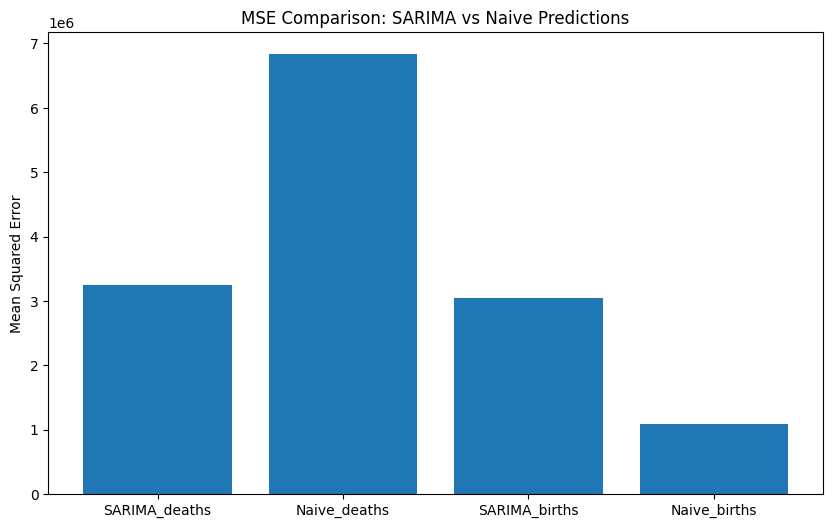

In [56]:
mse_values = [mse_sarima_deaths, mse_naive_deaths, mse_sarima_births, mse_naive_births]
labels = ['SARIMA_deaths', 'Naive_deaths', 'SARIMA_births', 'Naive_births']

plt.figure(figsize=(10, 6))
plt.bar(labels, mse_values)
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison: SARIMA vs Naive Predictions')
plt.show()

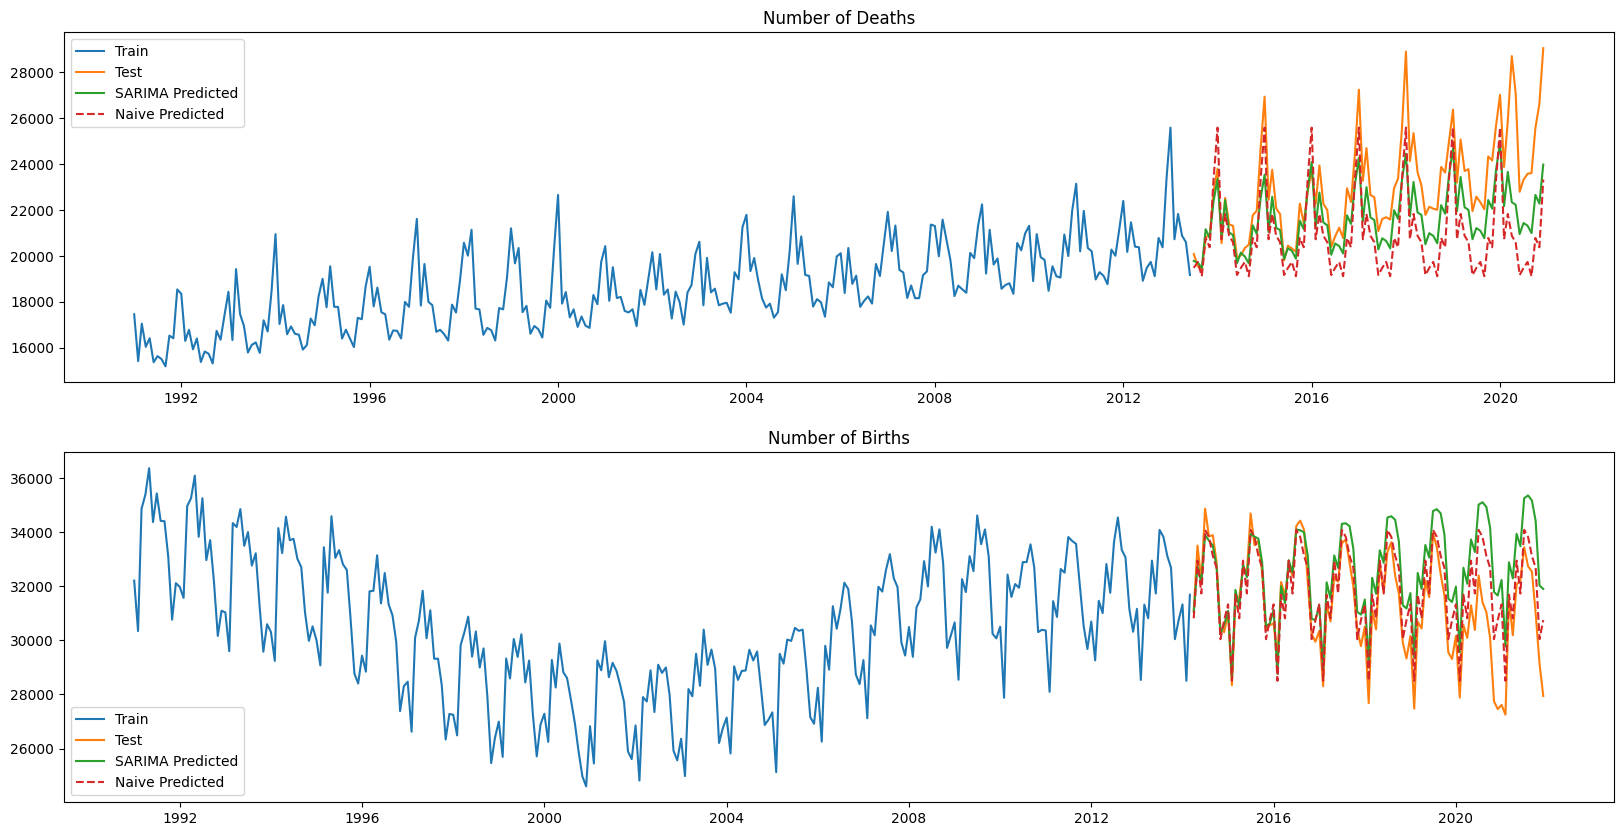

In [59]:
# Plot actual vs predicted
fig, axs = plt.subplots(2, figsize=(20,10))

# plot for deaths
axs[0].plot(train_deaths, label='Train')
axs[0].plot(test_deaths, label='Test')
axs[0].plot(forecast_deaths, label='SARIMA Predicted')
axs[0].plot(test_deaths.index, naive_deaths, label='Naive Predicted', linestyle='--')
axs[0].legend(loc='best')
axs[0].set_title('Number of Deaths')

# plot for births
axs[1].plot(train_births, label='Train')
axs[1].plot(test_births, label='Test')
axs[1].plot(forecast_births, label='SARIMA Predicted')
axs[1].plot(test_births.index, naive_births, label='Naive Predicted', linestyle='--')
axs[1].legend(loc='best')
axs[1].set_title('Number of Births')

plt.show()

09:52:19 - cmdstanpy - INFO - Chain [1] start processing
09:52:19 - cmdstanpy - INFO - Chain [1] done processing
09:52:20 - cmdstanpy - INFO - Chain [1] start processing
09:52:20 - cmdstanpy - INFO - Chain [1] done processing


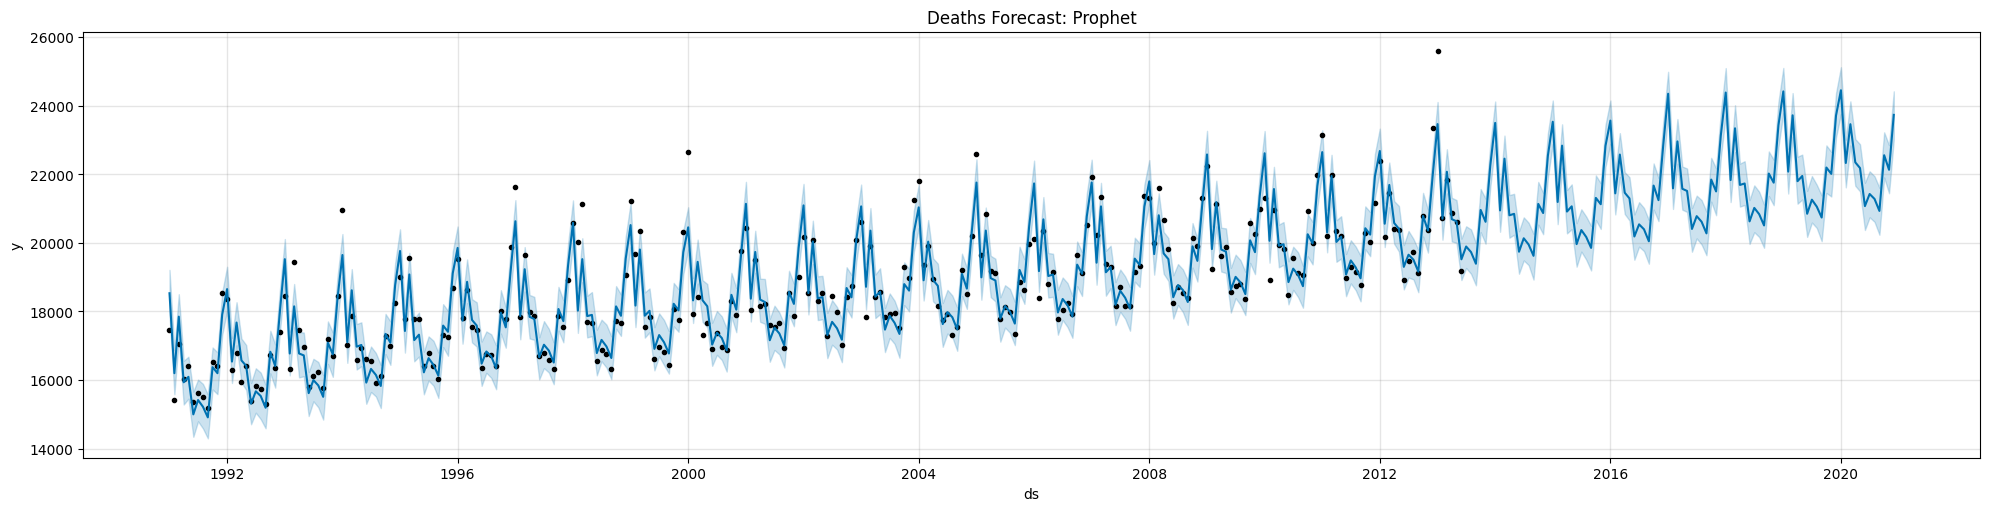

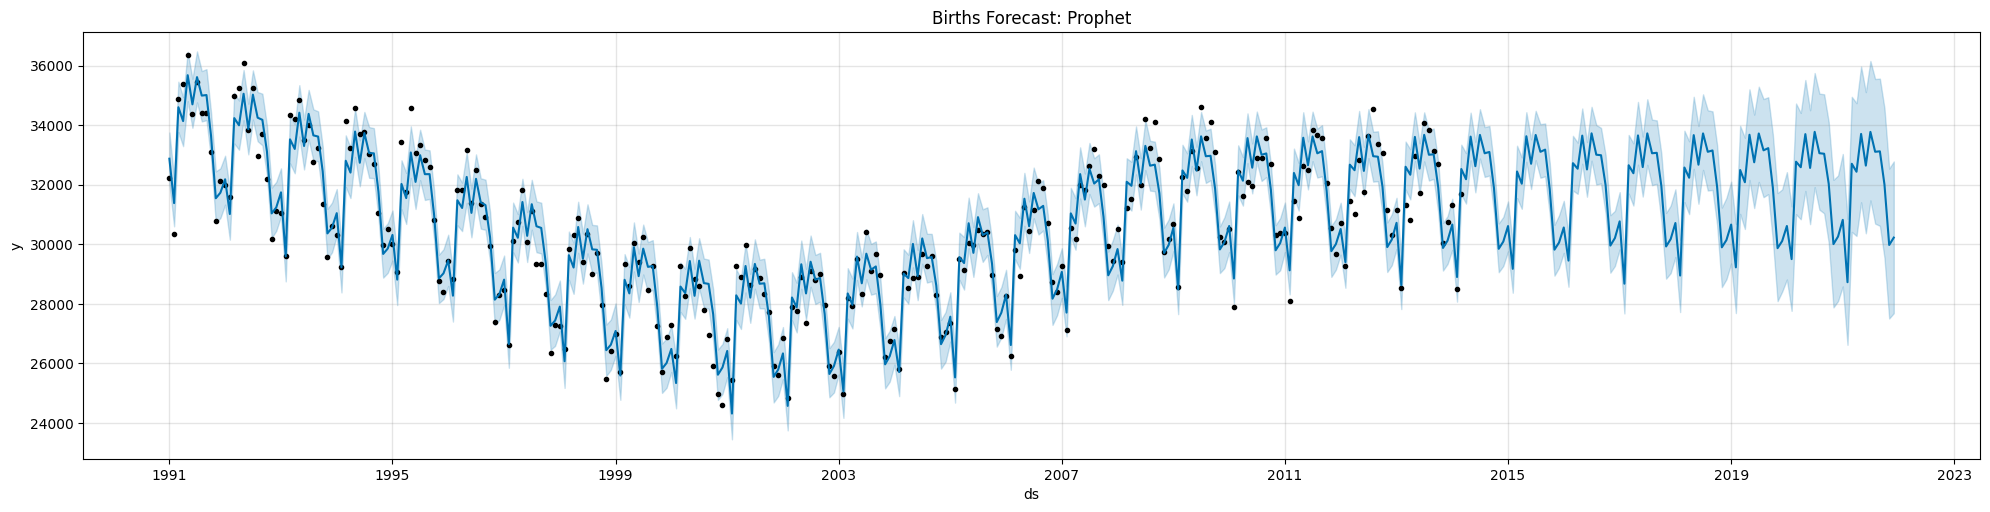

In [68]:
from prophet import Prophet

# Prophet requires columns ds (Date) and y (value)
deaths = train_deaths.reset_index().rename(columns={'date':'ds', 'value':'y'})
births = train_births.reset_index().rename(columns={'date':'ds', 'value':'y'})

# Make the prophet models and fit on the data 
# changepoint_prior_scale can be changed to achieve a better fit
prophet_deaths = Prophet(changepoint_prior_scale=0.05)
prophet_births = Prophet(changepoint_prior_scale=0.05)

prophet_deaths.fit(deaths)
prophet_births.fit(births)

# We need to specify the number of days to forecast
future_deaths = prophet_deaths.make_future_dataframe(periods=len(test_deaths), freq='MS')
future_births = prophet_births.make_future_dataframe(periods=len(test_births), freq='MS')

forecast_deaths = prophet_deaths.predict(future_deaths)
forecast_births = prophet_births.predict(future_births)

# Plot the prophet results
prophet_deaths.plot(forecast_deaths, figsize=(20, 5))
plt.title('Deaths Forecast: Prophet')
plt.show()

prophet_births.plot(forecast_births, figsize=(20, 5))
plt.title('Births Forecast: Prophet')
plt.show()


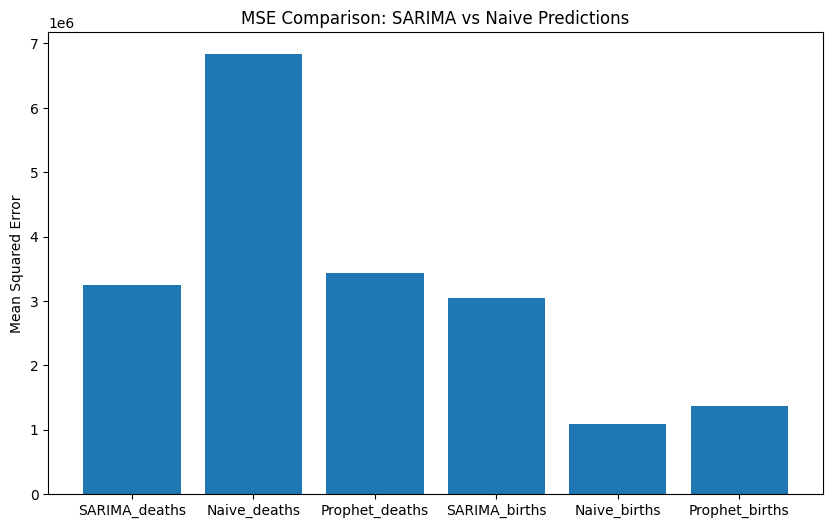

In [67]:
# Extract prophet predictions and calculate MSE
prophet_forecast_deaths = forecast_deaths.loc[len(train_deaths):, 'yhat']
prophet_forecast_births = forecast_births.loc[len(train_births):, 'yhat']

mse_prophet_deaths = mean_squared_error(test_deaths, prophet_forecast_deaths)
mse_prophet_births = mean_squared_error(test_births, prophet_forecast_births)

mse_values = [mse_sarima_deaths, mse_naive_deaths, mse_prophet_deaths, mse_sarima_births, mse_naive_births,  mse_prophet_births]
labels = ['SARIMA_deaths', 'Naive_deaths', 'Prophet_deaths', 'SARIMA_births', 'Naive_births',  'Prophet_births']

plt.figure(figsize=(10, 6))
plt.bar(labels, mse_values)
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison: SARIMA vs Naive Predictions')
plt.show()
